## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip install subword-nmt
! pip install nltk
! pip install torchtext==0.11.0
! pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.0 MB 16.9 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:40tcmalloc: large alloc 1147494400 bytes == 0x38dc8000 @  0x7f9ba87df615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 881.9 MB 19 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attemp

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
# path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
path_do_data = './data.txt'
# if not os.path.exists(path_do_data):
#     print("Dataset not found locally. Downloading from github.")
#     !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
#     path_do_data = './data.txt'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy

import random
import math
import time
import pandas as pd

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [4]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [5]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.legacy.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [6]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [7]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [8]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [9]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9278
Unique tokens in target (en) vocabulary: 6701


Here are tokens from original (RU) corpus:

In [10]:
SRC.vocab.itos[::1000]

['<unk>',
 'пляжем',
 'hills',
 'знаменитые',
 '88',
 'чиангмай',
 'next',
 'уотер',
 'дении',
 'стульчик']

And from target (EN) corpus:

In [11]:
TRG.vocab.itos[::1000]

['<unk>', 'paradise', 'executive', 'cancun', 'melaka', 'rocca', 'margate']

And here is example from train dataset:

In [12]:
print(vars(train_data.examples[9]))

{'trg': ['the', 'nearest', 'airport', 'is', 'odessa', 'international', 'airport', ',', '13', 'km', 'from', 'the', 'property', '.'], 'src': ['расстояние', 'до', 'международного', 'аэропорта', 'одессы', 'составляет', '13', 'км', '.']}


Let's check the length distributions:

Length distribution in Train data


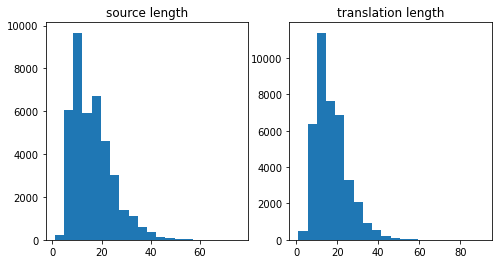

In [13]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


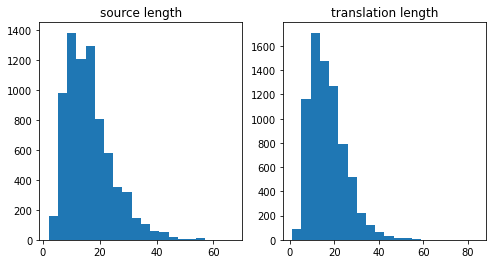

In [14]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
device

device(type='cuda')

In [17]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [18]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.legacy.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 39x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 41x128 (GPU 0)]
torch.Size([41, 128]) torch.Size([39, 128])


In [19]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [20]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [21]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9278, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6701, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6701, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,884,653 trainable parameters


In [23]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [24]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [25]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [26]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [27]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

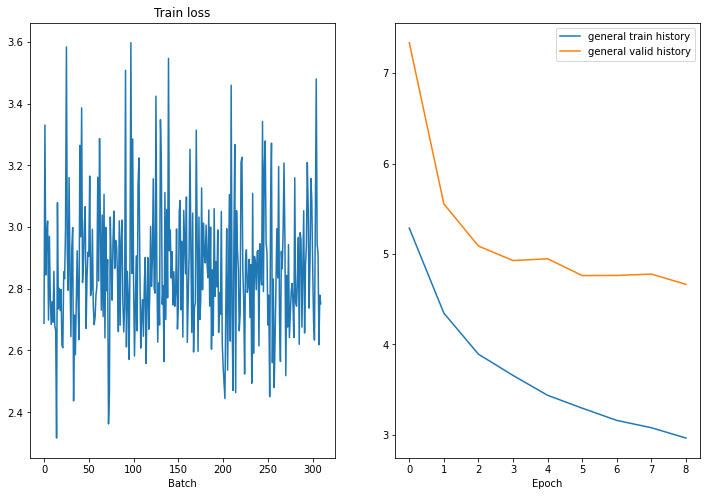

Epoch: 10 | Time: 1m 43s
	Train Loss: 2.861 | Train PPL:  17.481
	 Val. Loss: 4.754 |  Val. PPL: 115.990


In [28]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'LSTM_model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [30]:
del utils

In [31]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [32]:
batch = next(iter(test_iterator))

In [33]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: the property also offers packed lunches .
Generated: a .

Original: a public parking is available nearby .
Generated: free parking is available on site .



In [34]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [35]:
import tqdm

In [36]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:04, 12.81it/s]


In [37]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

15.005900302633709

## LSTM + attention

In [70]:
imp.reload(my_network)

<module 'my_network' from '/content/my_network.py'>

In [71]:
Encoder = my_network.Encoder
DecoderAttention = my_network.DecoderAttention
Seq2SeqAttention = my_network.Seq2SeqAttention

In [72]:
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec_attention = DecoderAttention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model_attention = Seq2SeqAttention(enc, dec_attention, device).to(device)

In [73]:
model_attention.apply(init_weights)

Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(9278, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): DecoderAttention(
    (embedding): Embedding(6701, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (attention): Attention(
      (linear_in): Linear(in_features=512, out_features=512, bias=False)
      (linear_out): Linear(in_features=1024, out_features=512, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (fc_out): Linear(in_features=512, out_features=6701, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [74]:
print(f'The model has {count_parameters(model_attention):,} trainable parameters')

The model has 15,671,085 trainable parameters


In [75]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer_attention = optim.Adam(model_attention.parameters())
criterion_attention = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [76]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

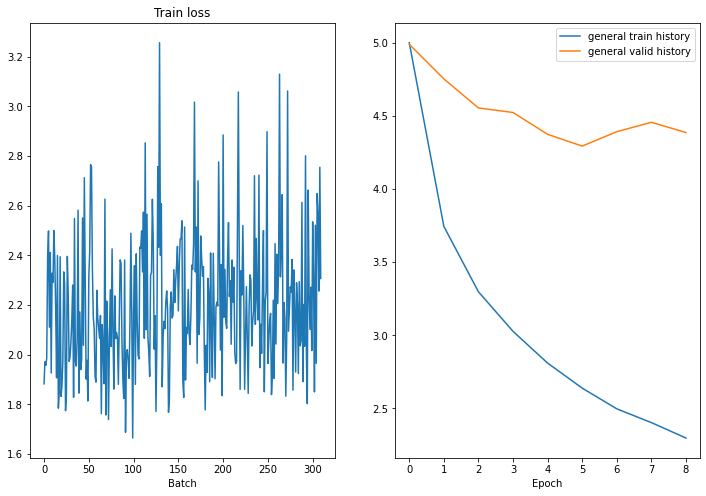

Epoch: 10 | Time: 2m 3s
	Train Loss: 2.205 | Train PPL:   9.066
	 Val. Loss: 4.363 |  Val. PPL:  78.487


In [77]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model_attention, train_iterator, optimizer_attention, criterion_attention, CLIP, train_history, valid_history)
    valid_loss = evaluate(model_attention, valid_iterator, criterion_attention)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_attention.state_dict(), 'LSTM_att_model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [78]:
batch = next(iter(test_iterator))

for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model_attention, TRG.vocab)

Original: the property also offers packed lunches .
Generated: packed lunches are also available .

Original: a public parking is available nearby .
Generated: public parking is possible nearby .



In [79]:
original_text = []
generated_text = []
model_attention.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model_attention(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

59it [00:04, 12.39it/s]


In [80]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

29.7463257536003

## GRU

In [86]:
imp.reload(my_network)

<module 'my_network' from '/content/my_network.py'>

In [87]:
EncoderGRU = my_network.EncoderGRU
DecoderGRU = my_network.DecoderGRU
Seq2SeqGRU = my_network.Seq2SeqGRU

In [88]:
encGRU = EncoderGRU(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec_GRU = DecoderGRU(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model_GRU = Seq2SeqGRU(encGRU, dec_GRU, device).to(device)

model_GRU.apply(init_weights)

PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer_GRU = optim.Adam(model_GRU.parameters())
criterion_GRU = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [89]:
print(f'The model has {count_parameters(model_GRU):,} trainable parameters')

The model has 13,045,549 trainable parameters


In [90]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

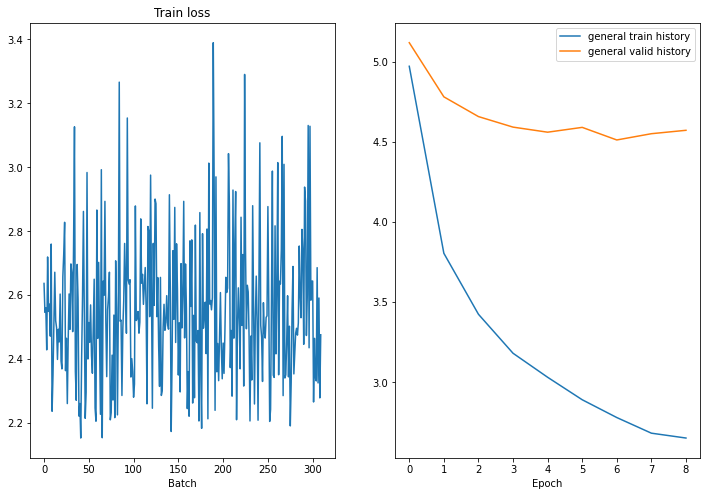

Epoch: 10 | Time: 1m 37s
	Train Loss: 2.552 | Train PPL:  12.837
	 Val. Loss: 4.575 |  Val. PPL:  97.002


In [91]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model_GRU, train_iterator, optimizer_GRU, criterion_GRU, CLIP, train_history, valid_history)
    valid_loss = evaluate(model_GRU, valid_iterator, criterion_GRU)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_GRU.state_dict(), 'GRU_model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [92]:
original_text = []
generated_text = []
model_GRU.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model_GRU(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

59it [00:04, 13.85it/s]


In [93]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

19.43784220901125

## GRU + attention 

In [94]:
imp.reload(my_network)

<module 'my_network' from '/content/my_network.py'>

In [95]:
EncoderGRU_Attention = my_network.EncoderGRU_Attention
DecoderGRU_Attention = my_network.DecoderGRU_Attention
Seq2SeqGRU_Attention = my_network.Seq2SeqGRU_Attention

In [96]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc_GRU_Attention = EncoderGRU_Attention(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec_GRU_Attention = DecoderGRU_Attention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model_GRU_Attention = Seq2SeqGRU_Attention(enc_GRU_Attention, dec_GRU_Attention, device).to(device)

model_GRU_Attention.apply(init_weights)

PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer_GRU_Attention = optim.Adam(model_GRU_Attention.parameters())
criterion_GRU_Attention = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [97]:
print(f'The model has {count_parameters(model_GRU_Attention):,} trainable parameters')

The model has 16,476,461 trainable parameters


In [98]:
train_history = []
valid_history = []

N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')

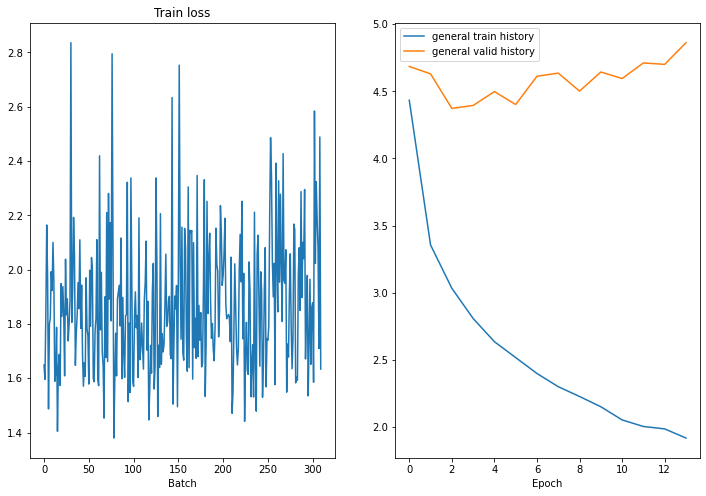

Epoch: 15 | Time: 2m 2s
	Train Loss: 1.867 | Train PPL:   6.470
	 Val. Loss: 4.741 |  Val. PPL: 114.495


In [99]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model_GRU_Attention, train_iterator, optimizer_GRU_Attention, criterion_GRU_Attention, CLIP, train_history, valid_history)
    valid_loss = evaluate(model_GRU_Attention, valid_iterator, criterion_GRU_Attention)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_GRU_Attention.state_dict(), 'GRU_att_model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [100]:
original_text = []
generated_text = []
model_GRU.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model_GRU_Attention(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

59it [00:04, 12.88it/s]


In [101]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

27.042370120100934

## GRU + attention + optimization

In [103]:
EncoderGRU_Attention = my_network.EncoderGRU_Attention
DecoderGRU_Attention = my_network.DecoderGRU_Attention
Seq2SeqGRU_Attention = my_network.Seq2SeqGRU_Attention

In [115]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc_GRU_Attention = EncoderGRU_Attention(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec_GRU_Attention = DecoderGRU_Attention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model_GRU_Attention2 = Seq2SeqGRU_Attention(enc_GRU_Attention, dec_GRU_Attention, device).to(device)

model_GRU_Attention2.apply(init_weights)

PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer_GRU_Attention = optim.Adam(model_GRU_Attention2.parameters())
criterion_GRU_Attention = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
lr_scheduler = ReduceLROnPlateau(optimizer_GRU_Attention, factor=0.2, patience=2)

In [116]:
print(f'The model has {count_parameters(model_GRU_Attention2):,} trainable parameters')

The model has 16,476,461 trainable parameters


In [117]:
train_history = []
valid_history = []

N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')

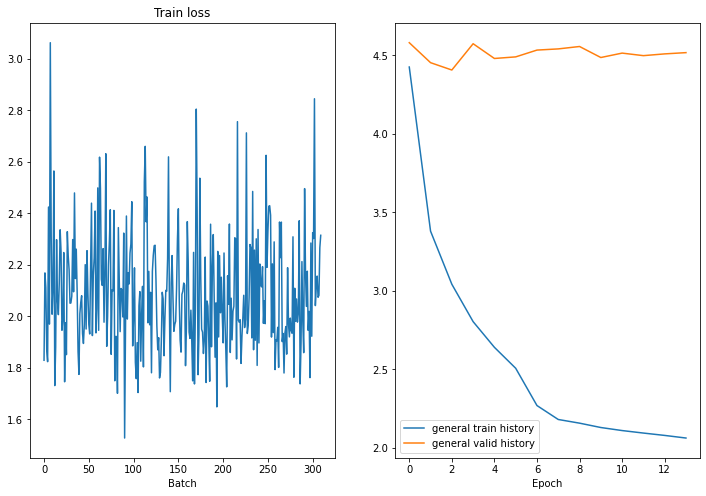

Epoch: 15 | Time: 2m 2s
	Train Loss: 2.085 | Train PPL:   8.044
	 Val. Loss: 4.519 |  Val. PPL:  91.757


In [118]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model_GRU_Attention2, train_iterator, optimizer_GRU_Attention, criterion_GRU_Attention, CLIP, train_history, valid_history)
    valid_loss = evaluate(model_GRU_Attention2, valid_iterator, criterion_GRU_Attention)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_GRU_Attention2.state_dict(), 'GRU_att_model2.pt')
    
    lr_scheduler.step(valid_loss)
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [121]:
original_text = []
generated_text = []
model_GRU.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model_GRU_Attention2(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

59it [00:05,  9.85it/s]


In [122]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

27.38985252551745

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points

In [127]:
result = pd.DataFrame({'model':['LTSM', 'LTSM + attention', 'GRU', 'GRU + attention',
                       'GRU + attention + optimization'],
              'Num parameters':[14884653,15671085,13045549,16476461,16476461],
              'Train time per epoch':['1m 43s','2m 3s','1m 37s', '2m 2s', '2m 2s'],
              'Val Loss':[4.754,4.363,4.575,4.741,4.519],
              'Blue Score':[15.005900302633709, 29.7463257536003, 19.43784220901125, 27.042370120100934, 27.38985252551745]})
result['Num parameters'] = result['Num parameters'].map('{:,.0f}'.format)
result['Val Loss'] = result['Val Loss'].map('{:,.4f}'.format)

In [128]:
result.head()

,model,Num parameters,Train time per epoch,Val Loss,Blue Score
0,LTSM,"14,884,653",1m 43s,4.7540,15.005900
1,LTSM + attention,"15,671,085",2m 3s,4.3630,29.746326
2,GRU,"13,045,549",1m 37s,4.5750,19.437842
3,GRU + attention,"16,476,461",2m 2s,4.7410,27.042370
4,GRU + attention + optimization,"16,476,461",2m 2s,4.5190,27.389853


Самый лучший результат получился для LSTM + attention, чистый GRU сработал лучше, чем LSTM, а использование attention и оптимизации позволило достичь близких результатов по точности с лучшим результатом.